Assignment 5 Part B

Load Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier

In [2]:
csvLink = 'diabetes+130-us+hospitals+for+years+1999-2008/diabetic_data.csv'

df = pd.read_csv(csvLink)

#verify data load
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

EDA Visualizations

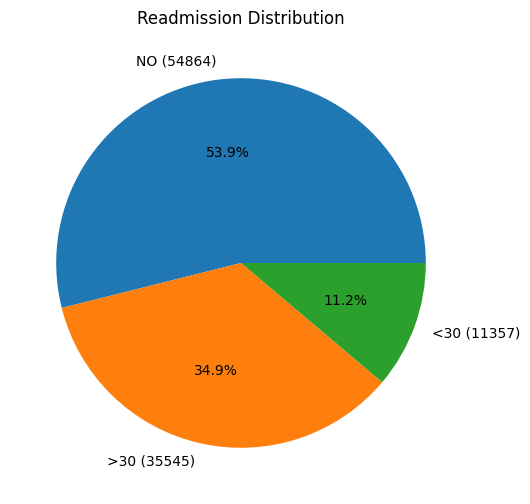

In [4]:
#distribution of  the target variable 'readdmitted'abs
readmissionCounts = df['readmitted'].value_counts()
labels=[f"{label} ({count})" for  label,count in zip(readmissionCounts.index,readmissionCounts.values)]
plt.figure(figsize=(9,6))

plt.pie(readmissionCounts,labels=labels, autopct='%1.1f%%',)
plt.title('Readmission Distribution' )

plt.show()

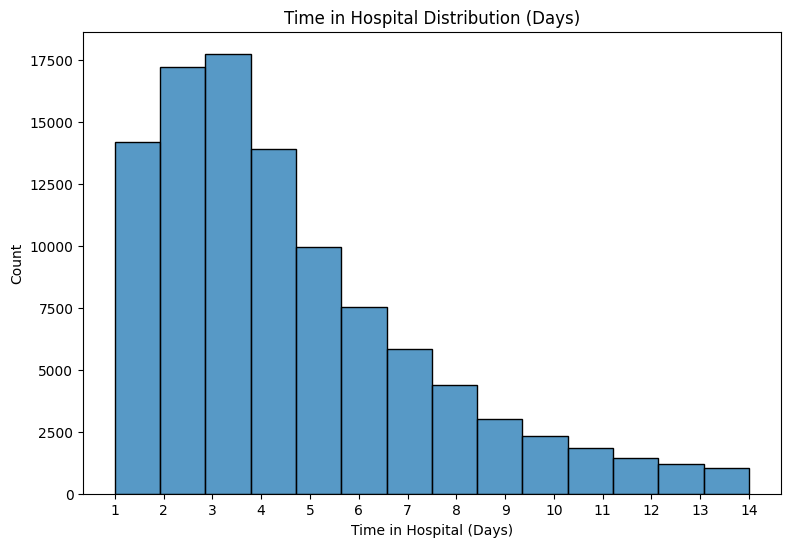

In [5]:
#histogram for time in hospital
plt.figure(figsize=(9,6))
sns.histplot(df['time_in_hospital'], bins= 14)
plt.title("Time in Hospital Distribution (Days)")

plt.xlabel("Time in Hospital (Days)")
plt.ylabel("Count")
plt.xticks(sorted(df['time_in_hospital'].unique()))

plt.show()

Text(0, 0.5, 'Time in Hospital (Days)')

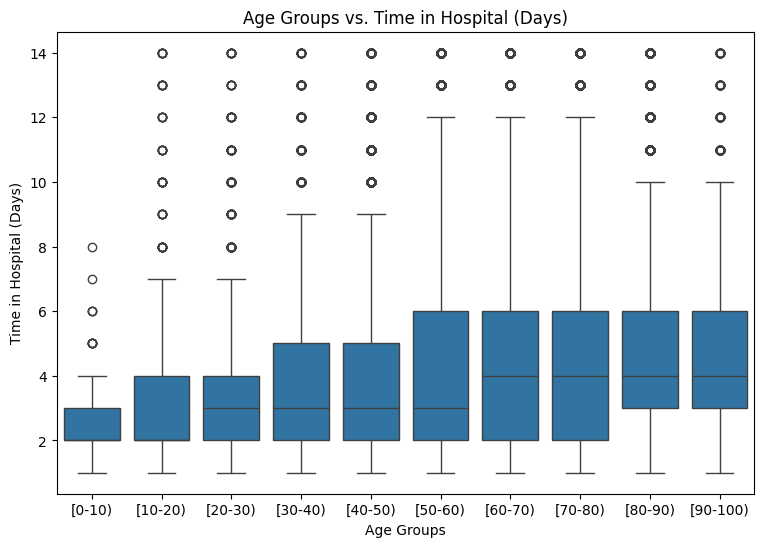

In [6]:
#boxplot of age group vs time in hospital
plt.figure(figsize=(9,6))

sns.boxplot(x='age',y= 'time_in_hospital', data =df, order=sorted(df['age'].unique()))
plt.title('Age Groups vs. Time in Hospital (Days)')

plt.xlabel('Age Groups' )
plt.ylabel( 'Time in Hospital (Days)')

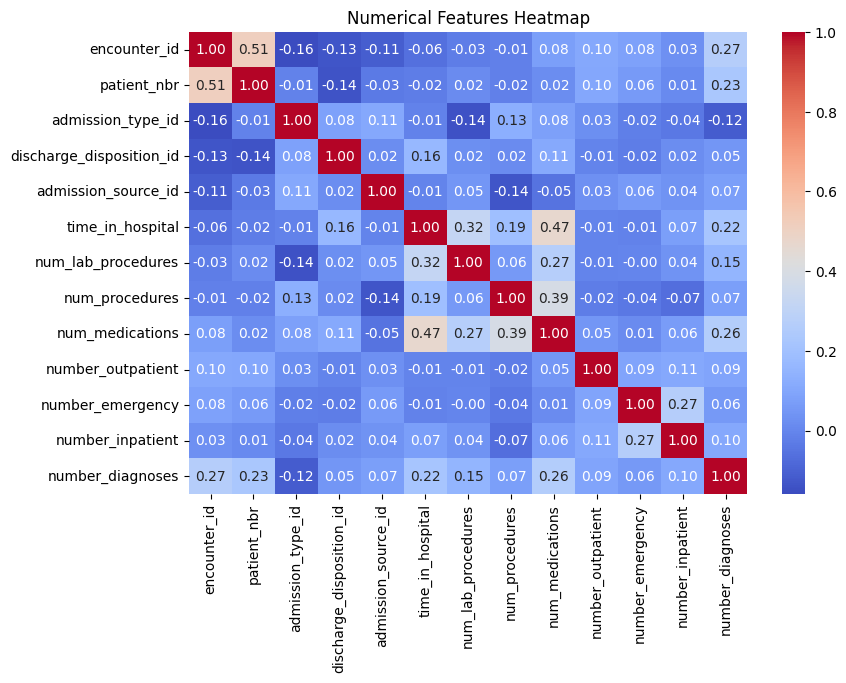

In [7]:
#heatmap between numeric features to find correlations
numericDF = df.select_dtypes(include=['number'])
correlation =numericDF.corr()

plt.figure(figsize=(9,6))
sns.heatmap(correlation,annot=True, cmap= "coolwarm",fmt= ".2f")
plt.title("Numerical Features Heatmap" )

plt.show()

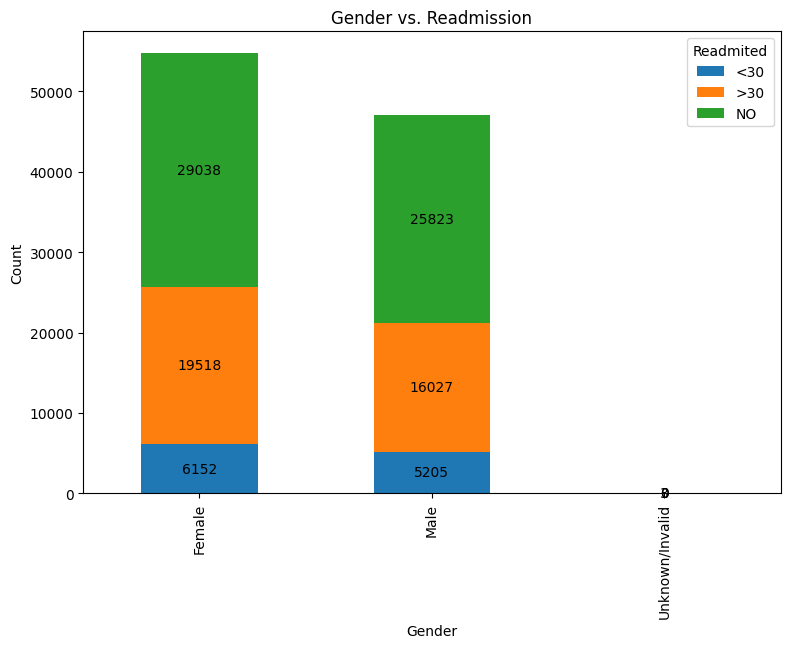

In [8]:
#bar chart to compare gender and readmission
genderReadmit = pd.crosstab(df['gender'],df['readmitted'])
bars = genderReadmit.plot(kind = "bar", stacked=True,figsize=(9,6))

#number the bars
for box in bars.containers:
    bars.bar_label(box,label_type='center')

plt.title('Gender vs. Readmission')

plt.xlabel('Gender')
plt.ylabel('Count')

plt.legend(title="Readmited")
plt.show()

Data Cleaning & Data Preprocessing

In [9]:
#handle the columns with too  many missing values
df=df.drop(columns=['weight', 'payer_code','medical_specialty'])

#remove irrelevant columns
df =df.drop(columns=['encounter_id','patient_nbr'])

#handle '?' cells
df= df.replace('?', np.nan)

#remove records with 'Unknown/Invalid' gender
df = df[df['gender']!='Unknown/Invalid']

#remove duplicates
df=df.drop_duplicates()


#fill missing categorical  values with 'Unknown'
categoricalColumns = df.select_dtypes(include = ['object']).columns
df[categoricalColumns]=df[categoricalColumns].fillna("Unknown")

#fiill mising numerical column values with median
numericalColumns = df.select_dtypes(include=['number']).columns
df[numericalColumns] =df[numericalColumns].fillna(df[numericalColumns].median())


 # map diag_1, diag_2,diag_3 to ICD9 codes
def map_diag(diag):
    try:
        code = float(diag)
        if (code >=390 and code < 460) or ( code ==785):
            return 'circulatory'
        elif (code >= 460 and code< 520) or (code== 786):
            return 'respiratory'
        elif (code >=520 and code < 580) or (code==787):
            return 'digestive'
        elif (code >= 250 and code< 251):
            return 'diabetes'
        elif (code >=800 and code < 1000):
            return 'injury'
        elif (code >= 710 and code< 740):
            return 'musculoskeletal'
        elif (code >= 580 and code<630) or (code== 788):
            return 'genitourinary'
        elif (code >= 140 and code <240):
            return 'neoplasms'
        else:
            return 'other'
    except:
        return 'other'
        
for column in ['diag_1', 'diag_2', 'diag_3']:
    df[column] = df[column].apply(map_diag)

#debug
print("Dataset Shape:", df.shape)
# df.head()
df.to_csv("debug.csv", index=False)
# df.info()


#encode  the target 
df['readmitted'] = df['readmitted'].map(lambda x: 1 if x=='<30'  else 0)

# encode categorical features
categoricalColumns = df.select_dtypes(include = ['object']).columns
for col in categoricalColumns:
    labelEncoder = LabelEncoder()
    df[col] =labelEncoder.fit_transform(df[col].astype(str))

#debug
# print("Dataset Shape:", df.shape)
# df.head()
# df.to_csv("debug.csv", index=False)
# df.info()

largeDF = df[df['readmitted'] == 0] # >30 or NO
smallDF = df[df['readmitted'] == 1] # <30

#debug
print("Dataset Shape Large:", largeDF.shape)
print("Dataset Shape Small:", smallDF.shape)

# #balance the dataset with 10 000 from each
# largeDFResample = resample(largeDF, replace=False, n_samples=10000, random_state=12)
# smallDFResample = resample(smallDF, replace = False, n_samples= 10000,random_state=12 )

# balance the dataset by upsampling the minority class to match the majority class size
# Upsample smallDF to match largeDF
smallDFResample = resample(smallDF, replace=True, n_samples=len(largeDF), random_state=12)
largeDFResample = largeDF

balancedDF =pd.concat([largeDFResample, smallDFResample])

#shuffle the dataset
balancedDF =balancedDF.sample(frac=1, random_state=12)

#Finalized Dataset
print("Dataset Shape:", balancedDF.shape)
balancedDF.to_csv("DiabetesBalancedPreprocessed.csv", index=False)


Dataset Shape: (101763, 45)
Dataset Shape Large: (90406, 45)
Dataset Shape Small: (11357, 45)
Dataset Shape: (180812, 45)


In [10]:
print("Class distribution after balancing:")
print(balancedDF['readmitted'].value_counts())

Class distribution after balancing:
readmitted
0    90406
1    90406
Name: count, dtype: int64


In [19]:
#train-test split for features and target
X =balancedDF.drop( columns=['readmitted'])
y=balancedDF['readmitted' ]

X_train,X_test,  y_train,y_test =train_test_split(X,y,test_size=0.2,  random_state= 12)

Hyperparameter Tuning

In [12]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

parameterGrid = {
    'logreg__C': [0.01, 1,100],
    'logreg__solver': ['newton-cg', 'lbfgs','liblinear'],
    'logreg__max_iter': [500,1000, 2000]  
}


logisticRegressionCV = GridSearchCV(pipe, parameterGrid,cv=5, n_jobs=-1)

logisticRegressionCV.fit(X_train, y_train)

#show all tuning results scores
print("Tuning Results:")
for i, score in enumerate(logisticRegressionCV.cv_results_['mean_test_score']):
    print( f"Score for params {logisticRegressionCV.cv_results_['params'][i]}: {score}")

print("Best Parameters:", logisticRegressionCV.best_params_ )
print("Best Cross-Validation Score:",logisticRegressionCV.best_score_)


KeyboardInterrupt: 

1) Logistic Regression Machine Learning Model 

In [13]:
#scale
pipelineLogReg = Pipeline([
    ('scaler', StandardScaler()),
    ('logisticRegression', LogisticRegression(max_iter=500, C=1, solver='lbfgs'))
])

#train 
pipelineLogReg.fit(X_train,y_train)

#debug
print("Xtrain Size:", X_train.shape )
print("Ytrain Size:", y_train.shape)

#predictions
y_pred = pipelineLogReg.predict( X_test)

# evaluate
print("Confusion Matrix:")
truePositives =sum((y_test==1) & (y_pred==1))
trueNegatives =sum( (y_test==0)& (y_pred==0 ))
falsePositives = sum((y_test==0) &(y_pred==1))
falseNegatives = sum((y_test==1 )& (y_pred==0) )

print(f"TP: {truePositives}  FP: {falsePositives}")
print(f"FN: {falseNegatives}  TN: {trueNegatives}")


#precision, recall and f1-score calculations
precision= truePositives /(truePositives +falsePositives) if (truePositives + falsePositives) >0 else 0
recall =truePositives /(truePositives +falseNegatives) if (truePositives + falseNegatives)>0 else 0
f1_score=2 * (precision* recall) /(precision  +recall) if (precision + recall) >0 else 0

print(f"Precision: {precision:.2f}")
print( f"Recall: { recall:.2f}")
print( f"F1 Score: {f1_score:.2f}")

print("Accuracy:",accuracy_score(y_test, y_pred))

#rmse
rmse =np.sqrt(( (y_test -y_pred) **  2).mean() )
print("RMSE:", rmse)


Xtrain Size: (144649, 44)
Ytrain Size: (144649,)
Confusion Matrix:
TP: 9445  FP: 5668
FN: 8645  TN: 12405
Precision: 0.62
Recall: 0.52
F1 Score: 0.57
Accuracy: 0.6042087216215469
RMSE: 0.6291194468290208


Hyperparameter Tuning for Random Forest

In [ ]:
#tune parameters for random forest classifier
parameterGridRFC = {
    'n_estimators': [100, 300,500],
    'max_features': ['sqrt','log2',None],
    'max_depth': [ 10, 20,  30],
    'min_samples_split': [2, 4,8]
}

randomForestClassifier = RandomForestClassifier(random_state= 12 )

randomForestClassifierCV = GridSearchCV(randomForestClassifier,  parameterGridRFC,cv=5,n_jobs=-1)

randomForestClassifierCV.fit(X_train,y_train)

#show all tuning results
print("Tuning Results:")
for i, score in  enumerate(randomForestClassifierCV.cv_results_['mean_test_score']):
    print(f"Score for params {randomForestClassifierCV.cv_results_['params'][i]}: {score}" )


print("Best Parameters:", randomForestClassifierCV.best_params_)
print("Best Cross-Validation Score:", randomForestClassifierCV.best_score_)


2) Random Forest Machine Learning Model 

In [14]:
randomForestClassify =RandomForestClassifier(n_estimators=300, max_depth=10,max_features=None, min_samples_split=8,  random_state=12)

randomForestClassify.fit(X_train,  y_train)

y_predict_ranFor =randomForestClassify.predict( X_test)

print("Confusion Matrix")
truePositivesRFC =sum((y_test==1) & (y_predict_ranFor==1))
trueNegativesRFC =sum( (y_test==0)& (y_predict_ranFor==0 ))
falsePositivesRFC = sum((y_test==0) &(y_predict_ranFor==1))
falseNegativesRFC= sum((y_test==1 )& (y_predict_ranFor==0) )

print(f"TP: {truePositivesRFC}  FP: {falsePositivesRFC}")
print(f"FN: {falseNegativesRFC}  TN: {trueNegativesRFC}")


#precision, recall and f1-score calculations
precisionRFC = truePositivesRFC/ (truePositivesRFC+ falsePositivesRFC) if (truePositivesRFC + falsePositivesRFC) >0 else 0
recallRFC= truePositivesRFC/ (truePositivesRFC +falseNegativesRFC) if (truePositivesRFC + falseNegativesRFC)>0 else 0
f1_scoreRFC=2 * (precisionRFC* recallRFC) /(precisionRFC + recallRFC) if(precisionRFC +recallRFC) > 0 else 0

print( f"Precision: {precisionRFC:.2f}")
print( f"Recall: {recallRFC:.2f}")
print(f"F1 Score: {f1_scoreRFC:.2f}" )

print("Accuracy:", accuracy_score(y_test, y_predict_ranFor))

#rmse calculation
rmseRFC =np.sqrt((( y_test -y_predict_ranFor) **  2).mean())

print("RMSE:",rmseRFC)





Confusion Matrix
TP: 12814  FP: 6025
FN: 5276  TN: 12048
Precision: 0.68
Recall: 0.71
F1 Score: 0.69
Accuracy: 0.687498271714183
RMSE: 0.5590185401986387


In [22]:
#train xgboost classifier model
xgboostClassifier = XGBClassifier(eval_metric='logloss', n_estimators=300, max_depth=30, learning_rate=1, random_state=12)

xgboostClassifier.fit(X_train, y_train)

#make predictions
y_predict_gbt = xgboostClassifier.predict(X_test)

#evaluate
accuracy = accuracy_score(y_test, y_predict_gbt)
print(f"Accuracy: {accuracy}")

#confusion matrix calculation
print("Confusion Matrix")
truePositivesXGB =sum((y_test==1) & (y_predict_gbt==1))
trueNegativesXGB =sum(((y_test==0)& (y_predict_gbt==0)))
falsePositivesXGB =sum(((y_test==0)& (y_predict_gbt==1)))
falseNegativesXGB =sum(((y_test==1)& (y_predict_gbt==0)))

#precision, recall, f1score calculations
precisionXGB = truePositivesXGB / (truePositivesXGB + falsePositivesXGB) if (truePositivesXGB + falsePositivesXGB) > 0 else 0
recallXGB = truePositivesXGB / (truePositivesXGB + falseNegativesXGB) if (truePositivesXGB + falseNegativesXGB) > 0 else 0
f1ScoreXGB = 2 * (precisionXGB * recallXGB) / (precisionXGB + recallXGB) if (precisionXGB + recallXGB) > 0 else 0

print(f"Precision: {precisionXGB}")
print(f"Recall: {recallXGB}")
print(f"F1 Score: {f1ScoreXGB}")

#rmse 

rmseXGB = np.sqrt(((y_test - y_predict_gbt) ** 2).mean())
print(f"RMSE: {rmseXGB}")


Accuracy: 0.9754721676852031
Confusion Matrix
Precision: 0.9547449114459424
Recall: 0.9982863460475401
F1 Score: 0.9760302661802459
RMSE: 0.15661364025779137


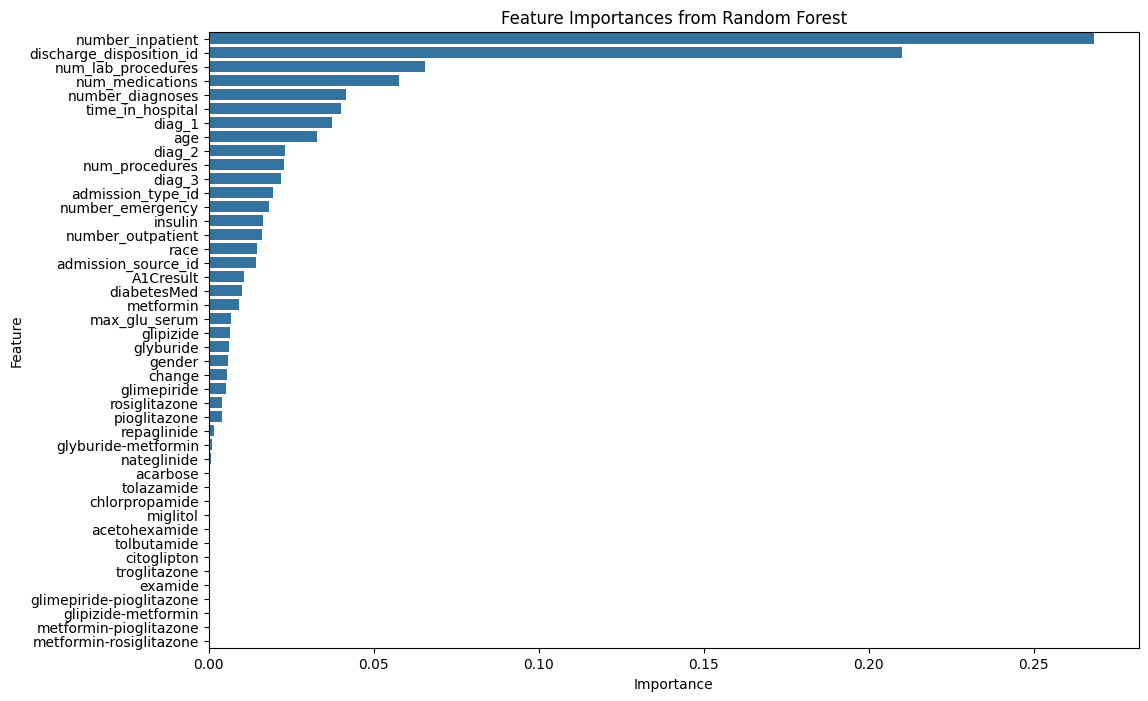

In [23]:
#extract key features that influenced the predictions from random forest
importancesModel =randomForestClassify.feature_importances_
featureNames = df.columns[:-1] 

feature_importance_df=pd.DataFrame({'Feature': featureNames, 'Importance': importancesModel} )
feature_importance_df=feature_importance_df.sort_values(by='Importance',ascending=False)


# Visualize feature importances
plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')

plt.show()
